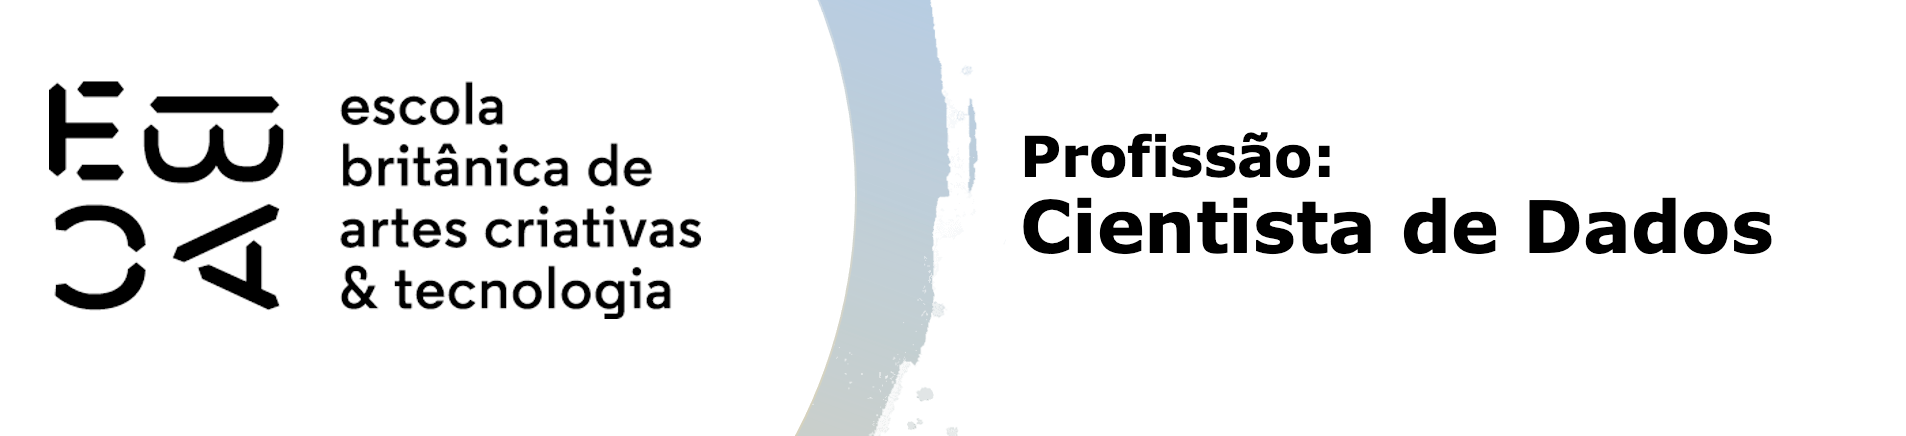

# Tarefa

Carregue a base ```NFP.ftr```. Essa base é proveniente do projeto #AMABiliDados, e contém dados da nota fiscal paulista cadastrados para doação automática para a AMA, Associação de Amigos do Autista. 

A *Nota Fiscal Paulista* é um programa de incentivo do governo do estado de São Paulo, que retorna um pedacinho do ICMS ao consumidor sempre que solicita o registro do seu CPF na nota. Nesse programa, o contribuinte pode direcionar seus créditos a uma ONG, e quando faz isso, sempre que faz esse consumidor cadastrado faz uma compra, os créditos de notas emitidas pelo mesmo estabelecimento não identificadas (notas sem CPF) são "arrastados" para a ONG na forma de uma doação.

Clique no link, caso queira saber mais sobre a [AMA](https://www.ama.org.br/site/).<br>
Clique no link, caso queira saber como o cidadão pode ser um [doador da NFP](https://doacao1.ama.org.br/sitenfp).

Essa base possui dados das notas cujos contribuintes direcionaram seus créditos à AMA. Seus campos estão descritos abaixo:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_pickle('base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


In [20]:
df.dtypes


CNPJ emit.                     object
Emitente                       object
No.                             int64
Data Emissão           datetime64[ns]
Valor NF                      float64
Data Registro          datetime64[ns]
Créditos                      float64
Situação do Crédito          category
Ano                             int64
Semestre                        int64
Retorno                       float64
flag_credito                    int64
categoria                      object
dtype: object

## Análise da probabilidade de retorno

Considere somente os dados de janeiro de 2020 em diante para esta análise.

- Analise a proporção de notas que tiveram retorno>0 por categoria de estabelecimento. Esta análise pode ser por tabela ou gráfico.

In [22]:
# Garantindo tipo datetime
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'])

# Filtro: janeiro de 2020 em diante
df_2020 = df[df['Data Emissão'] >= '2020-01-01'].copy()

df_2020.shape

(86956, 13)

In [24]:
df_2020['retorno_pos'] = (df_2020['Retorno'] > 0).astype(int)


In [26]:
tabela_categoria = (
    df_2020
    .groupby('categoria')
    .agg(
        total_notas=('retorno_pos', 'count'),
        notas_com_retorno=('retorno_pos', 'sum')
    )
)

tabela_categoria['proporcao_retorno'] = (
    tabela_categoria['notas_com_retorno'] / tabela_categoria['total_notas']
)

tabela_categoria = tabela_categoria.sort_values(
    'proporcao_retorno', ascending=False
)

tabela_categoria

,total_notas,notas_com_retorno,proporcao_retorno
categoria,,,
Restaurantes,2179,1626,0.746214
Alimentos,5050,3442,0.681584
Mercado,27558,13177,0.478155
Construção,16047,7523,0.468810
não definido,18407,6689,0.363394
Farmácia,10189,3582,0.351556
Auto posto,540,135,0.250000
Vestuário,1920,443,0.230729
Varejo,5066,701,0.138373


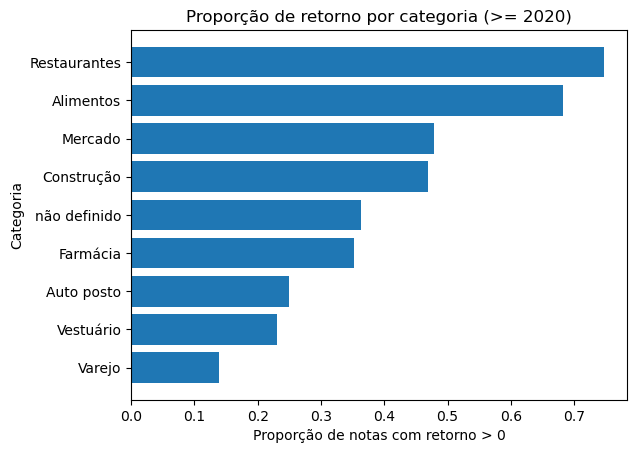

In [28]:
# Filtrar categorias com pelo menos 100 notas
tabela_plot = tabela_categoria[tabela_categoria['total_notas'] >= 100]

plt.figure()
plt.barh(
    tabela_plot.index,
    tabela_plot['proporcao_retorno']
)
plt.xlabel('Proporção de notas com retorno > 0')
plt.ylabel('Categoria')
plt.title('Proporção de retorno por categoria (>= 2020)')
plt.gca().invert_yaxis()
plt.show()


----

## Cálculo do WOE

- Calcule o WOE das categorias, sendo que o evento em questão é a nota ter retorno>0.
- Analise este WOE por tabela e por gráfico.

In [31]:
import numpy as np

In [33]:
# Filtro temporal
df_2020 = df[df['Data Emissão'] >= '2020-01-01'].copy()

# Evento: retorno > 0
df_2020['evento'] = (df_2020['Retorno'] > 0).astype(int)

In [35]:
# Contagem por categoria
woe_df = (
    df_2020
    .groupby('categoria')['evento']
    .agg(
        total='count',
        eventos='sum'
    )
)

woe_df['nao_eventos'] = woe_df['total'] - woe_df['eventos']

# Totais globais
total_eventos = woe_df['eventos'].sum()
total_nao_eventos = woe_df['nao_eventos'].sum()

In [37]:
epsilon = 0.5  # smoothing simples

woe_df['perc_eventos'] = (woe_df['eventos'] + epsilon) / (total_eventos + epsilon * len(woe_df))
woe_df['perc_nao_eventos'] = (woe_df['nao_eventos'] + epsilon) / (total_nao_eventos + epsilon * len(woe_df))

woe_df['WOE'] = np.log(woe_df['perc_eventos'] / woe_df['perc_nao_eventos'])

# Ordenar
woe_df = woe_df.sort_values('WOE', ascending=False)

woe_df


,total,eventos,nao_eventos,perc_eventos,perc_nao_eventos,WOE
categoria,,,,,,
Restaurantes,2179,1626,553,0.043580,0.011150,1.363175
Alimentos,5050,3442,1608,0.092237,0.032402,1.046147
Mercado,27558,13177,14381,0.353071,0.289701,0.197819
Construção,16047,7523,8524,0.201581,0.171718,0.160338
não definido,18407,6689,11718,0.179235,0.236058,-0.275379
Farmácia,10189,3582,6607,0.095988,0.133102,-0.326894
Auto posto,540,135,405,0.003631,0.008168,-0.810898
Vestuário,1920,443,1477,0.011883,0.029763,-0.918158
Varejo,5066,701,4365,0.018796,0.087939,-1.543016


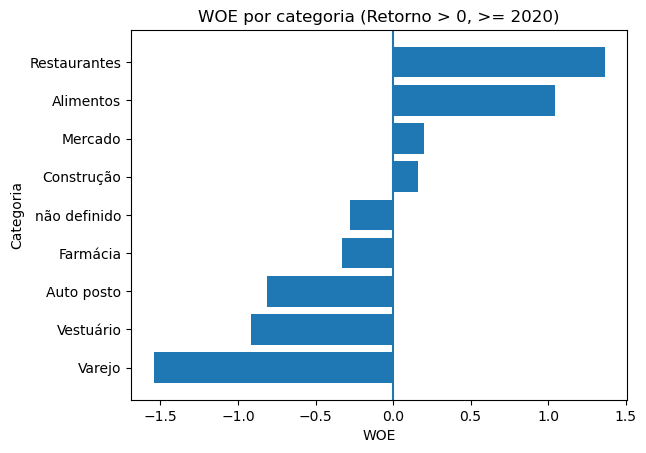

In [39]:
# Filtrar categorias com pelo menos 100 notas
woe_plot = woe_df[woe_df['total'] >= 100]

plt.figure()
plt.barh(
    woe_plot.index,
    woe_plot['WOE']
)
plt.axvline(0)
plt.xlabel('WOE')
plt.ylabel('Categoria')
plt.title('WOE por categoria (Retorno > 0, >= 2020)')
plt.gca().invert_yaxis()
plt.show()

Observa-se que a categoria do estabelecimento possui forte relação com a probabilidade de geração de créditos da Nota Fiscal Paulista. Categorias como Restaurantes e Alimentos apresentam WOE positivo elevado, indicando maior propensão ao retorno, enquanto Varejo, Vestuário e Auto Posto apresentam WOE negativo acentuado, refletindo menor probabilidade de geração de créditos, em linha com as regras fiscais do programa.

----

## Cálculo do *Information Value*

Calcule o *IV* dessa variável.

In [43]:
woe_df['IV_parcial'] = (
    (woe_df['perc_eventos'] - woe_df['perc_nao_eventos']) * woe_df['WOE']
)

IV_categoria = woe_df['IV_parcial'].sum()

IV_categoria

0.27869306882965567

In [45]:
woe_df[['total', 'eventos', 'nao_eventos', 'WOE', 'IV_parcial']]

,total,eventos,nao_eventos,WOE,IV_parcial
categoria,,,,,
Restaurantes,2179,1626,553,1.363175,0.044208
Alimentos,5050,3442,1608,1.046147,0.062596
Mercado,27558,13177,14381,0.197819,0.012536
Construção,16047,7523,8524,0.160338,0.004788
não definido,18407,6689,11718,-0.275379,0.015648
Farmácia,10189,3582,6607,-0.326894,0.012132
Auto posto,540,135,405,-0.810898,0.003680
Vestuário,1920,443,1477,-0.918158,0.016417
Varejo,5066,701,4365,-1.543016,0.106689


## Conclua

Não se esqueça de registrar suas conclusões em uma célula de texto. <font color='red'>**Sugestão:**</font> tente alterar a cor da fonte nesta célula para diferenciá-la das demais.


In [47]:
IV_categoria = woe_df['IV_parcial'].sum()
IV_categoria

0.27869306882965567

O Information Value (IV) da variável categoria foi estimado em 0,279, indicando poder preditivo médio na discriminação de notas com e sem retorno positivo de créditos. Esse resultado sugere que o tipo de estabelecimento é um fator relevante para a geração de créditos da Nota Fiscal Paulista, embora não seja suficiente isoladamente para explicar toda a variabilidade observada.

----